# Tutorial 4: Learning Rate Scheduling Strategies

**Difficulty**: Intermediate  
**Duration**: 30-40 minutes  
**Prerequisites**: [Tutorial 3](./optim_tutorial_03_optax_getting_started.ipynb) completion

## Learning Objectives
- Implement various learning rate schedules
- Combine optimizers with schedulers
- Understand when to use different scheduling strategies
- Monitor and visualize learning rate changes

## Topics Covered
1. **Basic schedulers**
   - StepLR: Step-wise decay
   - ExponentialLR: Exponential decay
   - MultiStepLR: Custom milestone-based decay

2. **Advanced schedulers**
   - CosineAnnealingLR: Cosine annealing
   - CyclicLR: Cyclic learning rates
   - OneCycleLR: Super-convergence training

3. **Adaptive scheduling**
   - ReduceLROnPlateau: Metric-based adaptation
   - WarmupScheduler: Gradual warmup strategies

4. **Scheduler composition**
   - ChainedScheduler: Sequential scheduling
   - SequentialLR: Phase-based scheduling

In [1]:
import time

import brainstate
import braintools

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

## 1. Setting up the Model and Data

We'll use a CNN model for this tutorial to demonstrate learning rate scheduling on a more complex architecture.

In [2]:
class SimpleNet(brainstate.nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.fc1 = brainstate.nn.Linear(784, 128)
        self.fc2 = brainstate.nn.Linear(128, num_classes)

    def __call__(self, x):
        x = self.fc1(x)
        x = jax.nn.relu(x)
        x = self.fc2(x)
        return x

In [3]:
# Create synthetic CIFAR-like data
def create_synthetic_data(n_train=5000, n_val=1000, seed=42):
    """Create synthetic image classification data."""
    with brainstate.random.seed_context(seed):
        # Training data
        X_train = brainstate.random.normal(size=(n_train, 784)) * 0.5
        y_train = brainstate.random.randint(0, 10, size=(n_train,))

        # Validation data
        X_val = brainstate.random.normal(size=(n_val, 784)) * 0.5
        y_val = brainstate.random.randint(0, 10, size=(n_val,))

    return X_train, y_train, X_val, y_val


X_train, y_train, X_val, y_val = create_synthetic_data()
print(f"Training data: {X_train.shape}, Validation data: {X_val.shape}")

Training data: (5000, 784), Validation data: (1000, 784)


## 2. Gradient Computation and Training Loop

Following the style from the optax tutorial, we'll define our training infrastructure.

In [4]:
def compute_loss_and_grads(model, X, y, param_states):
    """Compute loss and gradients following braintools style."""

    def loss_fn():
        # Forward pass
        logits = model(X)

        # Cross-entropy loss
        log_probs = jax.nn.log_softmax(logits, axis=-1)
        one_hot = jax.nn.one_hot(y, num_classes=10)
        loss = -jnp.mean(jnp.sum(one_hot * log_probs, axis=-1))

        return loss

    # Compute loss and gradients
    loss = loss_fn()
    grads = brainstate.transform.grad(loss_fn, grad_states=param_states)()

    # Compute accuracy
    logits = model(X)
    predictions = jnp.argmax(logits, axis=-1)
    accuracy = jnp.mean(predictions == y)

    return loss, grads, accuracy



In [5]:
def train_with_scheduler(
    model: brainstate.nn.Module,
    optimizer: braintools.optim.OptaxOptimizer,
    X_train, y_train, X_val, y_val,
    n_epochs=50,
    batch_size=128,
    verbose=True,
    track_lr=True
):
    """Train model with learning rate scheduling."""

    # Get parameter states
    param_states = braintools.optim.UniqueStateManager(
        model.states(brainstate.ParamState)
    ).to_pytree()

    # Initialize optimizer
    optimizer.register_trainable_weights(param_states)

    @brainstate.transform.jit
    def train_step(X_batch, y_batch):
        loss, grads, acc = compute_loss_and_grads(model, X_batch, y_batch, param_states)
        optimizer.update(grads)
        return loss, acc

    @brainstate.transform.jit
    def eval_step(X_batch, y_batch):
        loss, _, acc = compute_loss_and_grads(model, X_batch, y_batch, param_states)
        return loss, acc

    # Training history
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'lr': [],
        'epoch_time': []
    }

    n_batches = len(X_train) // batch_size

    for epoch in range(n_epochs):
        epoch_start = time.time()

        # Shuffle training data
        perm = brainstate.random.permutation(len(X_train))
        X_train_shuffled = X_train[perm]
        y_train_shuffled = y_train[perm]

        # Training
        train_losses = []
        train_accs = []

        for batch_idx in range(n_batches):
            start_idx = batch_idx * batch_size
            end_idx = start_idx + batch_size
            X_batch = X_train_shuffled[start_idx:end_idx]
            y_batch = y_train_shuffled[start_idx:end_idx]

            loss, acc = train_step(X_batch, y_batch)
            train_losses.append(float(loss))
            train_accs.append(float(acc))

        # Validation
        val_loss, val_acc = eval_step(X_val, y_val)

        # Update learning rate scheduler
        optimizer.lr.step()

        # Track current learning rate
        if track_lr:
            current_lr = optimizer.lr.get_lr()[0]
        else:
            current_lr = 0.0

        # Record metrics
        history['train_loss'].append(np.mean(train_losses))
        history['train_acc'].append(np.mean(train_accs))
        history['val_loss'].append(float(val_loss))
        history['val_acc'].append(float(val_acc))
        history['lr'].append(current_lr)
        history['epoch_time'].append(time.time() - epoch_start)

        if verbose and (epoch + 1) % 10 == 0:
            print(
                f"Epoch {epoch + 1}/{n_epochs} - "
                f"Loss: {history['train_loss'][-1]:.4f}, "
                f"Acc: {history['train_acc'][-1]:.4f}, "
                f"Val Loss: {history['val_loss'][-1]:.4f}, "
                f"Val Acc: {history['val_acc'][-1]:.4f}, "
                f"LR: {current_lr:.6f}"
            )

    return history



## 3. Basic Learning Rate Schedulers

Let's implement and compare basic learning rate scheduling strategies.

### 3.1 Step Decay Scheduler

In [6]:
# Create model with Step LR scheduler
model_step = SimpleNet()

# Step decay: reduce LR by gamma every step_size epochs
step_lr = braintools.optim.StepLR(
    base_lr=0.01,
    step_size=10,
    gamma=0.5,
    last_epoch=0
)

optimizer_step = braintools.optim.Adam(lr=step_lr)

print("Training with Step LR Decay...")
history_step = train_with_scheduler(
    model_step, optimizer_step,
    X_train, y_train, X_val, y_val,
    n_epochs=40, batch_size=128
)

Training with Step LR Decay...
Epoch 10/40 - Loss: 0.0030, Acc: 1.0000, Val Loss: 5.8856, Val Acc: 0.1010, LR: 0.005000
Epoch 20/40 - Loss: 0.0013, Acc: 1.0000, Val Loss: 6.1810, Val Acc: 0.1010, LR: 0.002500
Epoch 30/40 - Loss: 0.0010, Acc: 1.0000, Val Loss: 6.3180, Val Acc: 0.0990, LR: 0.001250
Epoch 40/40 - Loss: 0.0008, Acc: 1.0000, Val Loss: 6.3916, Val Acc: 0.0990, LR: 0.000625


### 3.2 Exponential Decay Scheduler

In [7]:
# Create model with Exponential LR scheduler
model_exp = SimpleNet()

# Exponential decay: lr = init_lr * gamma^epoch
exp_lr = braintools.optim.ExponentialLR(
    base_lr=0.01,
    gamma=0.95,
    last_epoch=0
)

optimizer_exp = braintools.optim.Adam(lr=exp_lr)

print("Training with Exponential LR Decay...")
history_exp = train_with_scheduler(
    model_exp, optimizer_exp,
    X_train, y_train, X_val, y_val,
    n_epochs=40, batch_size=128
)

Training with Exponential LR Decay...
Epoch 10/40 - Loss: 0.0049, Acc: 1.0000, Val Loss: 5.5179, Val Acc: 0.1120, LR: 0.005987
Epoch 20/40 - Loss: 0.0019, Acc: 1.0000, Val Loss: 5.9411, Val Acc: 0.1130, LR: 0.003585
Epoch 30/40 - Loss: 0.0012, Acc: 1.0000, Val Loss: 6.1494, Val Acc: 0.1130, LR: 0.002146
Epoch 40/40 - Loss: 0.0009, Acc: 1.0000, Val Loss: 6.2729, Val Acc: 0.1140, LR: 0.001285


### 3.3 MultiStep Decay Scheduler

In [8]:
# Create model with MultiStep LR scheduler
model_multistep = SimpleNet()

# MultiStep decay: reduce LR at specific milestones
multistep_lr = braintools.optim.MultiStepLR(
    base_lr=0.01,
    milestones=[10, 20, 30],
    gamma=0.3,
    last_epoch=0
)

optimizer_multistep = braintools.optim.Adam(lr=multistep_lr)

print("Training with MultiStep LR Decay...")
history_multistep = train_with_scheduler(
    model_multistep, optimizer_multistep,
    X_train, y_train, X_val, y_val,
    n_epochs=40, batch_size=128
)

Training with MultiStep LR Decay...
Epoch 10/40 - Loss: 0.0030, Acc: 1.0000, Val Loss: 5.8258, Val Acc: 0.1270, LR: 0.003000
Epoch 20/40 - Loss: 0.0017, Acc: 1.0000, Val Loss: 6.0254, Val Acc: 0.1250, LR: 0.000900
Epoch 30/40 - Loss: 0.0014, Acc: 1.0000, Val Loss: 6.0906, Val Acc: 0.1230, LR: 0.000270
Epoch 40/40 - Loss: 0.0013, Acc: 1.0000, Val Loss: 6.1144, Val Acc: 0.1240, LR: 0.000270


### 3.4 Visualizing Basic Schedulers

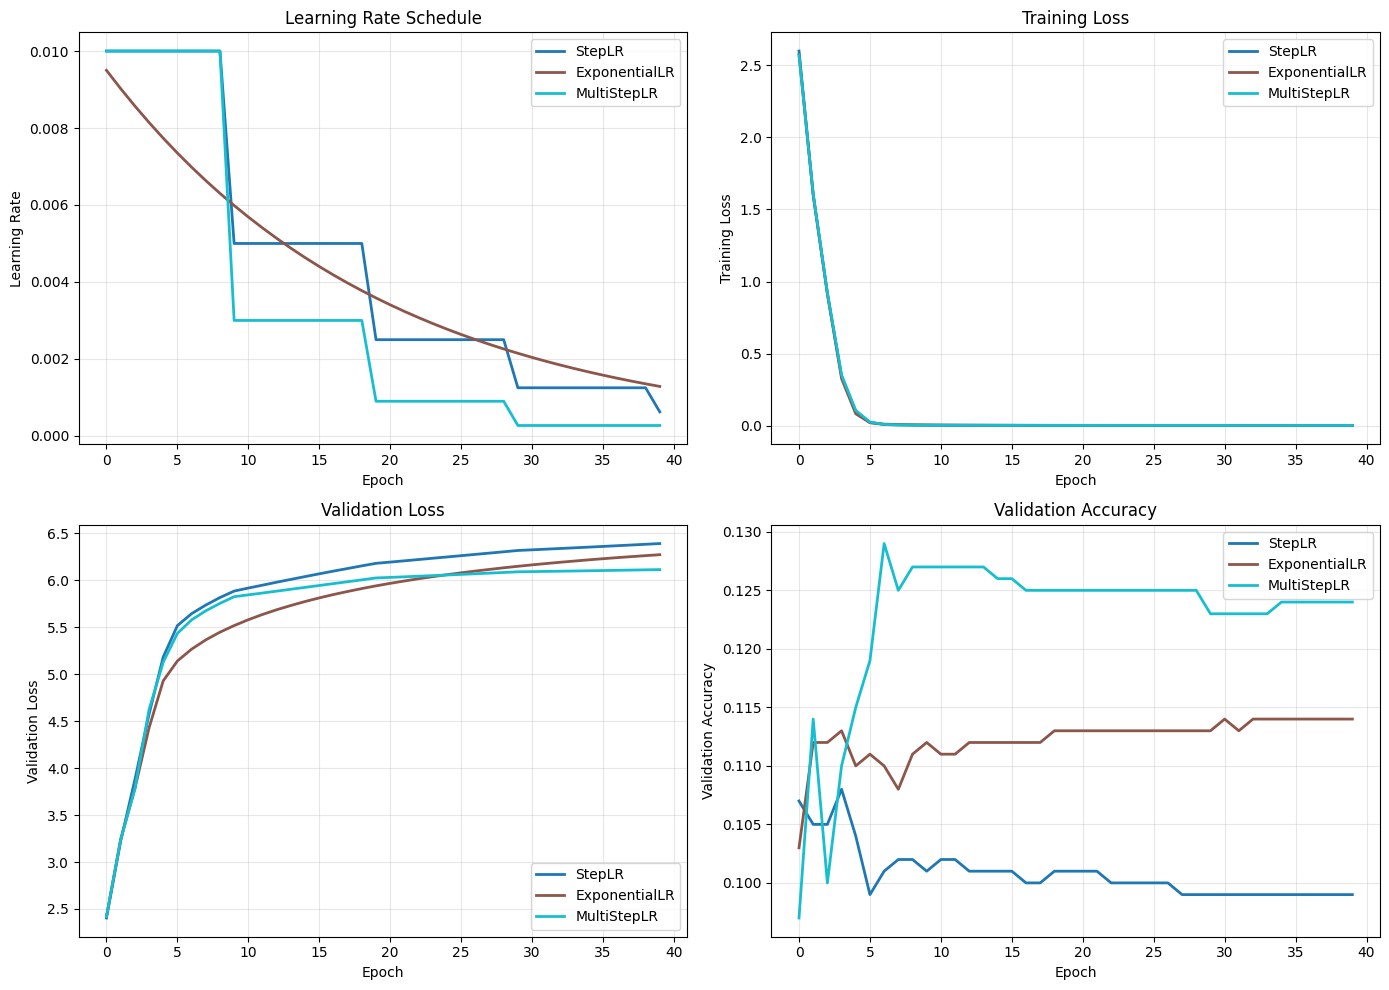

In [9]:
def plot_lr_schedules(histories, names, colors=None):
    """Plot learning rate schedules and training curves."""
    if colors is None:
        colors = plt.cm.tab10(np.linspace(0, 1, len(histories)))

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Learning rate over time
    ax = axes[0, 0]
    for history, name, color in zip(histories, names, colors):
        ax.plot(history['lr'], label=name, color=color, linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Learning Rate')
    ax.set_title('Learning Rate Schedule')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Training loss
    ax = axes[0, 1]
    for history, name, color in zip(histories, names, colors):
        ax.plot(history['train_loss'], label=name, color=color, linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Training Loss')
    ax.set_title('Training Loss')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Validation loss
    ax = axes[1, 0]
    for history, name, color in zip(histories, names, colors):
        ax.plot(history['val_loss'], label=name, color=color, linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Validation Loss')
    ax.set_title('Validation Loss')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Validation accuracy
    ax = axes[1, 1]
    for history, name, color in zip(histories, names, colors):
        ax.plot(history['val_acc'], label=name, color=color, linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Validation Accuracy')
    ax.set_title('Validation Accuracy')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


# Compare basic schedulers
plot_lr_schedules(
    [history_step, history_exp, history_multistep],
    ['StepLR', 'ExponentialLR', 'MultiStepLR']
)

## 4. Advanced Learning Rate Schedulers

Now let's explore more sophisticated scheduling strategies.

### 4.1 Cosine Annealing Scheduler

In [10]:
# Create model with Cosine Annealing scheduler
model_cosine = SimpleNet()

# Cosine annealing: smoothly decreases LR following cosine curve
cosine_lr = braintools.optim.CosineAnnealingLR(
    base_lr=0.01,
    T_max=20,  # Half period of cosine
    eta_min=0.0001,  # Minimum LR
    last_epoch=0
)

optimizer_cosine = braintools.optim.Adam(lr=cosine_lr)

print("Training with Cosine Annealing...")
history_cosine = train_with_scheduler(
    model_cosine, optimizer_cosine,
    X_train, y_train, X_val, y_val,
    n_epochs=40, batch_size=128
)

Training with Cosine Annealing...
Epoch 10/40 - Loss: 0.0042, Acc: 1.0000, Val Loss: 5.7146, Val Acc: 0.0970, LR: 0.005050
Epoch 20/40 - Loss: 0.0025, Acc: 1.0000, Val Loss: 5.9071, Val Acc: 0.0940, LR: 0.000100
Epoch 30/40 - Loss: 0.0018, Acc: 1.0000, Val Loss: 6.0856, Val Acc: 0.0950, LR: 0.005050
Epoch 40/40 - Loss: 0.0006, Acc: 1.0000, Val Loss: 6.6336, Val Acc: 0.0990, LR: 0.010000


### 4.2 Cyclic Learning Rate (CyclicLR)

In [11]:
# Create model with Cyclic LR scheduler
model_cyclic = SimpleNet()

# Cyclic LR: oscillates between base_lr and max_lr
cyclic_lr = braintools.optim.CyclicLR(
    base_lr=0.001,
    max_lr=0.01,
    step_size_up=5,  # Epochs to increase LR
    step_size_down=5,  # Epochs to decrease LR
    mode='triangular2',  # Halve max_lr after each cycle
    last_epoch=0
)

optimizer_cyclic = braintools.optim.SGD(lr=cyclic_lr, momentum=0.9)

print("Training with Cyclic LR...")
history_cyclic = train_with_scheduler(
    model_cyclic, optimizer_cyclic,
    X_train, y_train, X_val, y_val,
    n_epochs=40, batch_size=128
)

Training with Cyclic LR...
Epoch 10/40 - Loss: 1.8272, Acc: 0.4343, Val Loss: 2.4771, Val Acc: 0.0870, LR: 0.001000
Epoch 20/40 - Loss: 1.4326, Acc: 0.6396, Val Loss: 2.6086, Val Acc: 0.0920, LR: 0.001000
Epoch 30/40 - Loss: 1.1654, Acc: 0.7534, Val Loss: 2.7336, Val Acc: 0.0940, LR: 0.001000
Epoch 40/40 - Loss: 0.9810, Acc: 0.8237, Val Loss: 2.8377, Val Acc: 0.0990, LR: 0.001000


### 4.3 OneCycle Learning Rate

In [12]:
# Create model with OneCycle scheduler
model_onecycle = SimpleNet()

# OneCycle: super-convergence with one cycle
onecycle_lr = braintools.optim.OneCycleLR(
    max_lr=0.01,
    total_steps=40,  # Total training epochs
    pct_start=0.3,  # Percentage of cycle for increasing LR
    anneal_strategy='cos',
    div_factor=25.0,  # Initial lr = max_lr / div_factor
    final_div_factor=10000.0,  # Final lr = max_lr / final_div_factor
    last_epoch=0
)

optimizer_onecycle = braintools.optim.SGD(lr=onecycle_lr, momentum=0.9)

print("Training with OneCycle LR...")
history_onecycle = train_with_scheduler(
    model_onecycle, optimizer_onecycle,
    X_train, y_train, X_val, y_val,
    n_epochs=40, batch_size=128
)

Training with OneCycle LR...
Epoch 10/40 - Loss: 1.9626, Acc: 0.3482, Val Loss: 2.4337, Val Acc: 0.1100, LR: 0.009200
Epoch 20/40 - Loss: 0.9132, Acc: 0.8271, Val Loss: 2.9077, Val Acc: 0.1270, LR: 0.007660
Epoch 30/40 - Loss: 0.4346, Acc: 0.9830, Val Loss: 3.2900, Val Acc: 0.1220, LR: 0.002341
Epoch 40/40 - Loss: 0.3730, Acc: 0.9926, Val Loss: 3.3486, Val Acc: 0.1200, LR: 0.000001


### 4.4 Comparing Advanced Schedulers

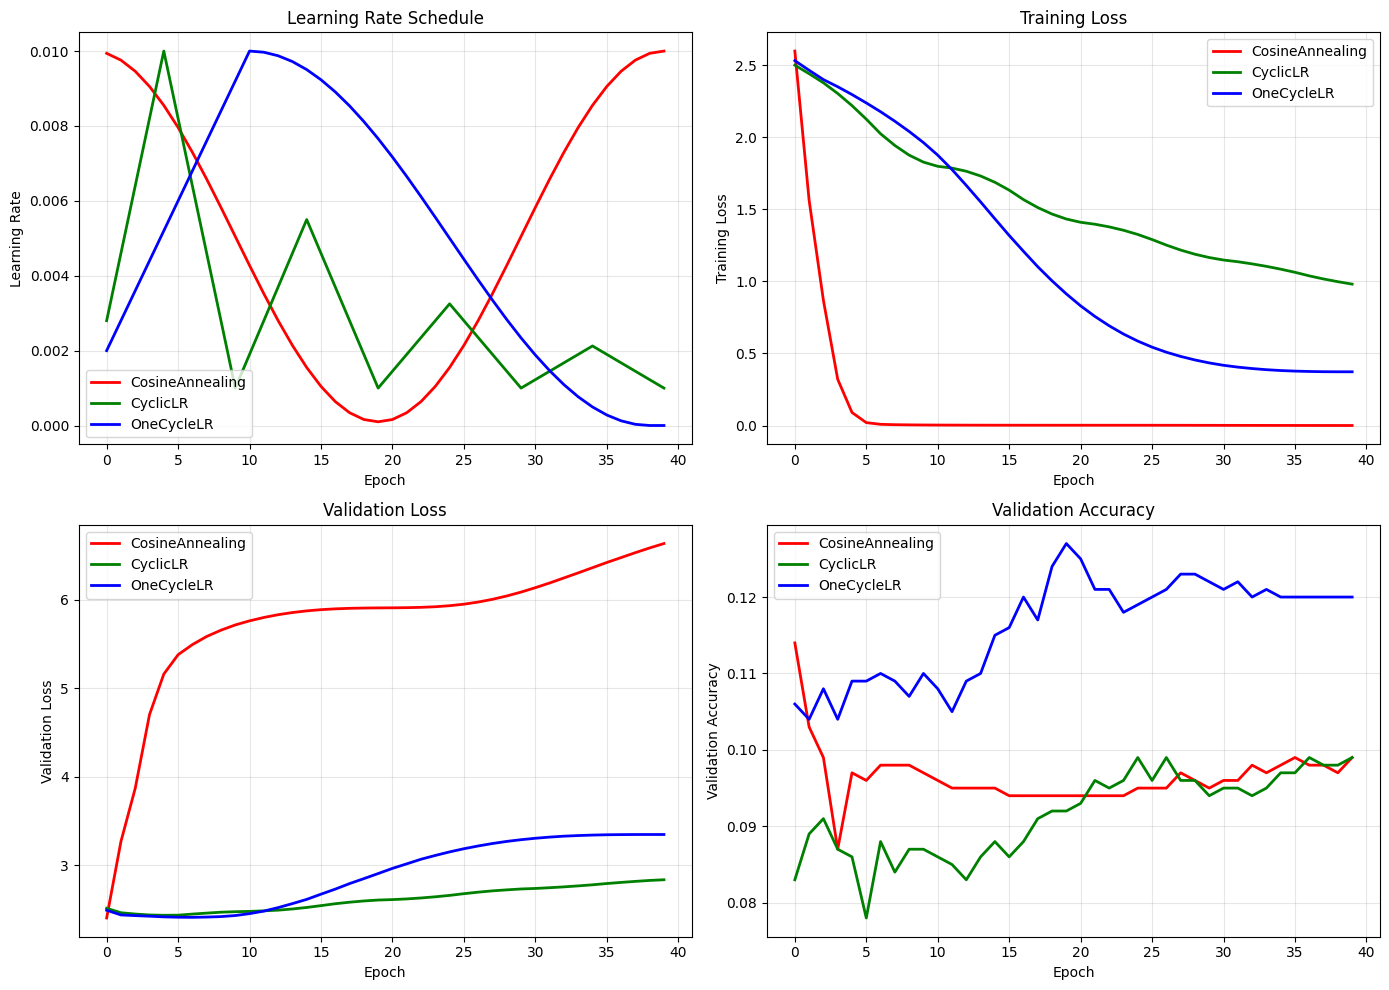

In [13]:
# Compare advanced schedulers
plot_lr_schedules(
    [history_cosine, history_cyclic, history_onecycle],
    ['CosineAnnealing', 'CyclicLR', 'OneCycleLR'],
    colors=['red', 'green', 'blue']
)

## 5. Adaptive Scheduling with Warmup

Let's implement adaptive scheduling strategies including warmup and plateau-based reduction.

### 5.1 Warmup Scheduler

In [14]:
# Create model with warmup scheduler
model_warmup = SimpleNet()

warmup_lr = braintools.optim.WarmupScheduler(
    base_lr=0.01,
    warmup_epochs=5,
    warmup_start_lr=0.0001,
)

optimizer_warmup = braintools.optim.Adam(lr=warmup_lr)

print("Training with Warmup + Exponential Decay...")
history_warmup = train_with_scheduler(
    model_warmup, optimizer_warmup,
    X_train, y_train, X_val, y_val,
    n_epochs=40, batch_size=128
)

Training with Warmup + Exponential Decay...
Epoch 10/40 - Loss: 0.0104, Acc: 0.9996, Val Loss: 6.5678, Val Acc: 0.1150, LR: 0.010000
Epoch 20/40 - Loss: 0.0008, Acc: 1.0000, Val Loss: 6.9188, Val Acc: 0.1160, LR: 0.010000
Epoch 30/40 - Loss: 0.0004, Acc: 1.0000, Val Loss: 7.1367, Val Acc: 0.1170, LR: 0.010000
Epoch 40/40 - Loss: 0.0002, Acc: 1.0000, Val Loss: 7.3129, Val Acc: 0.1170, LR: 0.010000


### 5.2 ReduceLROnPlateau Scheduler

In [15]:
# Train with ReduceLROnPlateau
def train_with_plateau_scheduler(
    model, optimizer_class, X_train, y_train, X_val, y_val,
    n_epochs=50, batch_size=128
):
    """Special training loop for ReduceLROnPlateau."""

    plateau_lr = braintools.optim.ReduceLROnPlateau(
        base_lr=0.01,
        mode='min',
        factor=0.5,
        patience=5
    )

    optimizer = optimizer_class(lr=plateau_lr)

    # Get parameter states
    param_states = braintools.optim.UniqueStateManager(
        model.states(brainstate.ParamState)
    ).to_pytree()

    optimizer.register_trainable_weights(param_states)

    @brainstate.transform.jit
    def train_step(X_batch, y_batch):
        loss, grads, acc = compute_loss_and_grads(model, X_batch, y_batch, param_states)
        optimizer.update(grads)
        return loss, acc

    @brainstate.transform.jit
    def eval_step(X_batch, y_batch):
        loss, _, acc = compute_loss_and_grads(model, X_batch, y_batch, param_states)
        return loss, acc

    history = {
        'train_loss': [],
        'val_loss': [],
        'val_acc': [],
        'lr': []
    }

    n_batches = len(X_train) // batch_size

    for epoch in range(n_epochs):
        # Training
        perm = brainstate.random.permutation(len(X_train))
        X_train_shuffled = X_train[perm]
        y_train_shuffled = y_train[perm]

        train_losses = []
        for batch_idx in range(n_batches):
            start_idx = batch_idx * batch_size
            end_idx = start_idx + batch_size
            X_batch = X_train_shuffled[start_idx:end_idx]
            y_batch = y_train_shuffled[start_idx:end_idx]

            loss, _ = train_step(X_batch, y_batch)
            train_losses.append(float(loss))

        # Validation
        val_loss, val_acc = eval_step(X_val, y_val)
        val_loss = float(val_loss)

        # Update scheduler based on validation loss
        plateau_lr.step(metric=val_loss)

        # Record metrics
        history['train_loss'].append(np.mean(train_losses))
        history['val_loss'].append(val_loss)
        history['val_acc'].append(float(val_acc))
        history['lr'].append(plateau_lr.get_lr()[0])

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{n_epochs} - "
                  f"Train Loss: {history['train_loss'][-1]:.4f}, "
                  f"Val Loss: {val_loss:.4f}, "
                  f"LR: {plateau_lr.get_lr()[0]:.6f}")

    return history


# Create model for plateau scheduler
model_plateau = SimpleNet()

print("Training with ReduceLROnPlateau...")
history_plateau = train_with_plateau_scheduler(
    model_plateau, braintools.optim.Adam,
    X_train, y_train, X_val, y_val,
    n_epochs=40, batch_size=128
)

Training with ReduceLROnPlateau...
Epoch 10/40 - Train Loss: 0.0039, Val Loss: 5.7269, LR: 0.005000
Epoch 20/40 - Train Loss: 0.0019, Val Loss: 5.9691, LR: 0.001250
Epoch 30/40 - Train Loss: 0.0016, Val Loss: 6.0443, LR: 0.000625
Epoch 40/40 - Train Loss: 0.0015, Val Loss: 6.0727, LR: 0.000156


## 6. Scheduler Composition

Let's create composite schedulers that combine multiple scheduling strategies.

In [16]:
# Create a complex scheduler: warmup -> cosine -> exponential
warmup = braintools.optim.WarmupScheduler(
    base_lr=0.01, warmup_epochs=5, warmup_start_lr=0.0001,
)

cosine = braintools.optim.CosineAnnealingLR(
    base_lr=0.01, T_max=15, eta_min=0.001
)

exponential = braintools.optim.ExponentialLR(
    base_lr=0.001, gamma=0.9
)

chained_scheduler = braintools.optim.SequentialLR(
    schedulers=[warmup, cosine, exponential],
    milestones=[5, 20]  # Switch at epoch 5 and 20
)

# Train with chained scheduler
model_chained = SimpleNet()
optimizer_chained = braintools.optim.Adam(lr=chained_scheduler)

print("Training with Chained Scheduler (Warmup -> Cosine -> Exponential)...")
history_chained = train_with_scheduler(
    model_chained, optimizer_chained,
    X_train, y_train, X_val, y_val,
    n_epochs=40, batch_size=128
)

Training with Chained Scheduler (Warmup -> Cosine -> Exponential)...
Epoch 10/40 - Loss: 0.0030, Acc: 1.0000, Val Loss: 5.9528, Val Acc: 0.1060, LR: 0.003250
Epoch 20/40 - Loss: 0.0009, Acc: 1.0000, Val Loss: 6.4556, Val Acc: 0.1070, LR: 0.000122
Epoch 30/40 - Loss: 0.0004, Acc: 1.0000, Val Loss: 6.7822, Val Acc: 0.1060, LR: 0.000042
Epoch 40/40 - Loss: 0.0003, Acc: 1.0000, Val Loss: 7.0344, Val Acc: 0.1050, LR: 0.000015


## 7. Visualizing Learning Rate Trajectories

Let's create comprehensive visualizations of all our learning rate scheduling strategies.

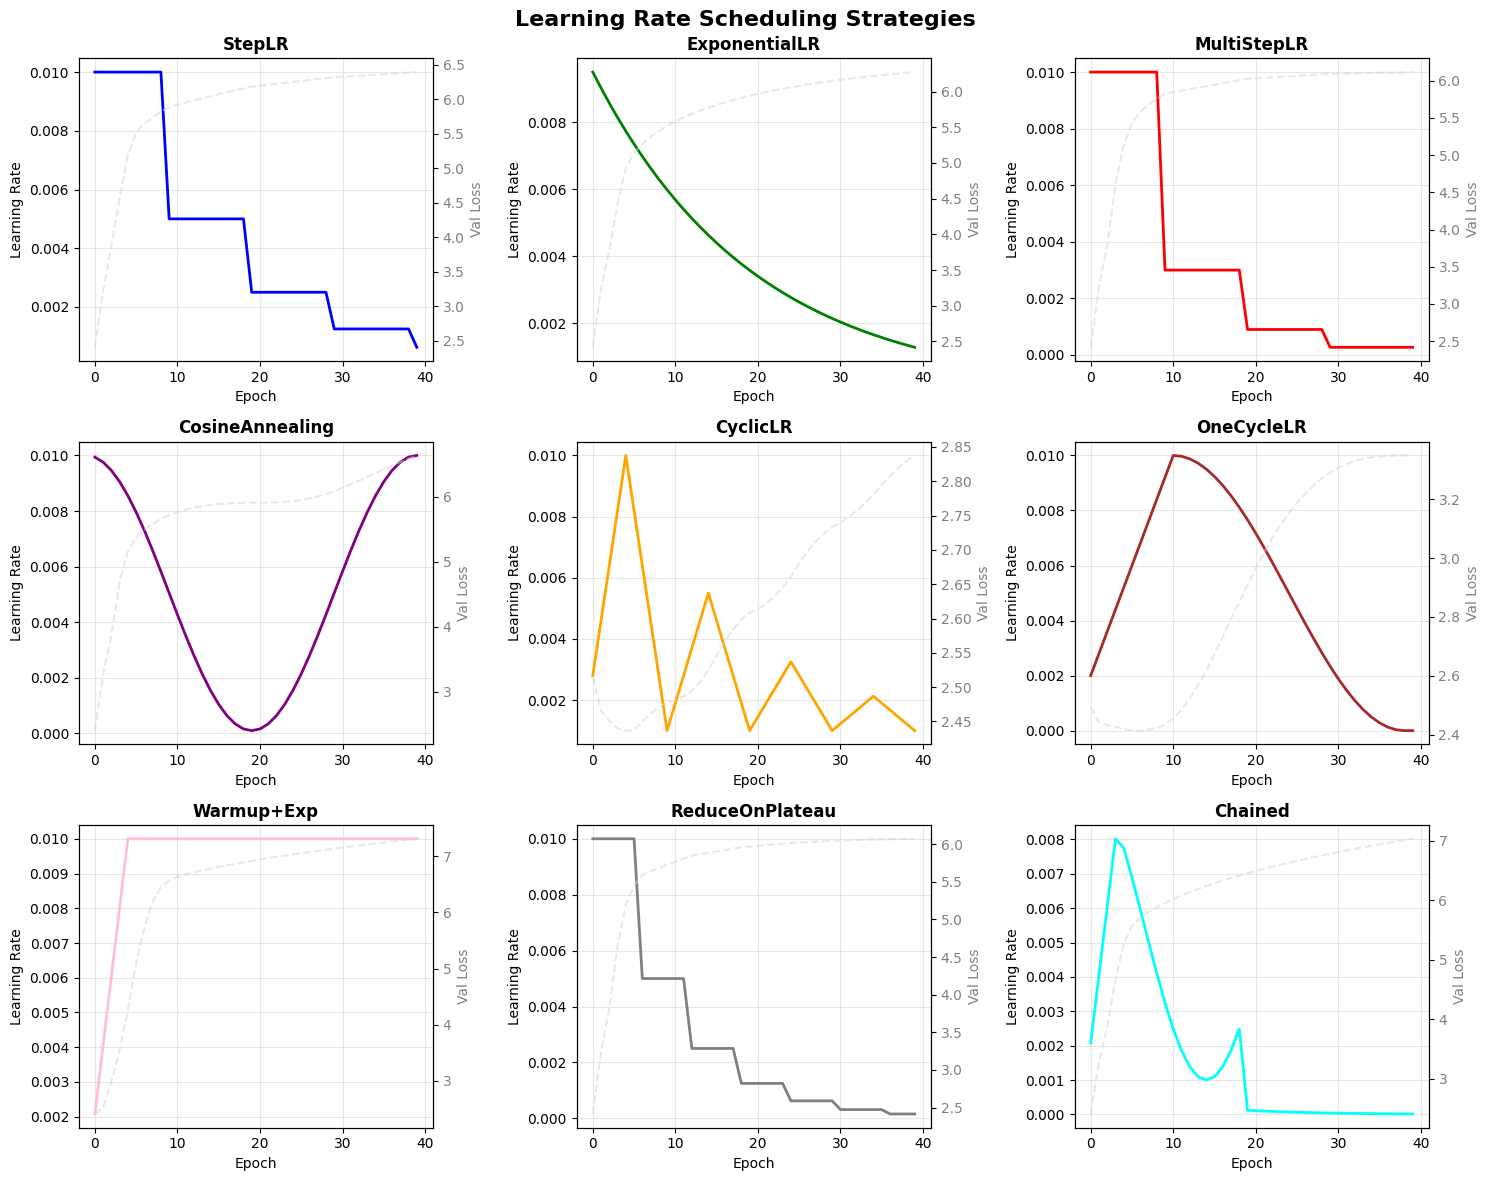

In [17]:
def visualize_all_schedules():
    """Create a comprehensive visualization of all LR schedules."""

    fig, axes = plt.subplots(3, 3, figsize=(15, 12))

    schedules_data = [
        (history_step, 'StepLR', 'blue'),
        (history_exp, 'ExponentialLR', 'green'),
        (history_multistep, 'MultiStepLR', 'red'),
        (history_cosine, 'CosineAnnealing', 'purple'),
        (history_cyclic, 'CyclicLR', 'orange'),
        (history_onecycle, 'OneCycleLR', 'brown'),
        (history_warmup, 'Warmup+Exp', 'pink'),
        (history_plateau, 'ReduceOnPlateau', 'gray'),
        (history_chained, 'Chained', 'cyan')
    ]

    for idx, (history, name, color) in enumerate(schedules_data):
        ax = axes[idx // 3, idx % 3]

        # Plot learning rate
        ax.plot(history['lr'], color=color, linewidth=2)
        ax.set_title(name, fontsize=12, fontweight='bold')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Learning Rate')
        ax.grid(True, alpha=0.3)

        # Add validation loss on secondary y-axis
        ax2 = ax.twinx()
        ax2.plot(history['val_loss'], color='lightgray', alpha=0.5, linestyle='--')
        ax2.set_ylabel('Val Loss', color='gray')
        ax2.tick_params(axis='y', labelcolor='gray')

    plt.suptitle('Learning Rate Scheduling Strategies', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()


visualize_all_schedules()

## 8. Performance Comparison

Let's compare the final performance of all scheduling strategies.

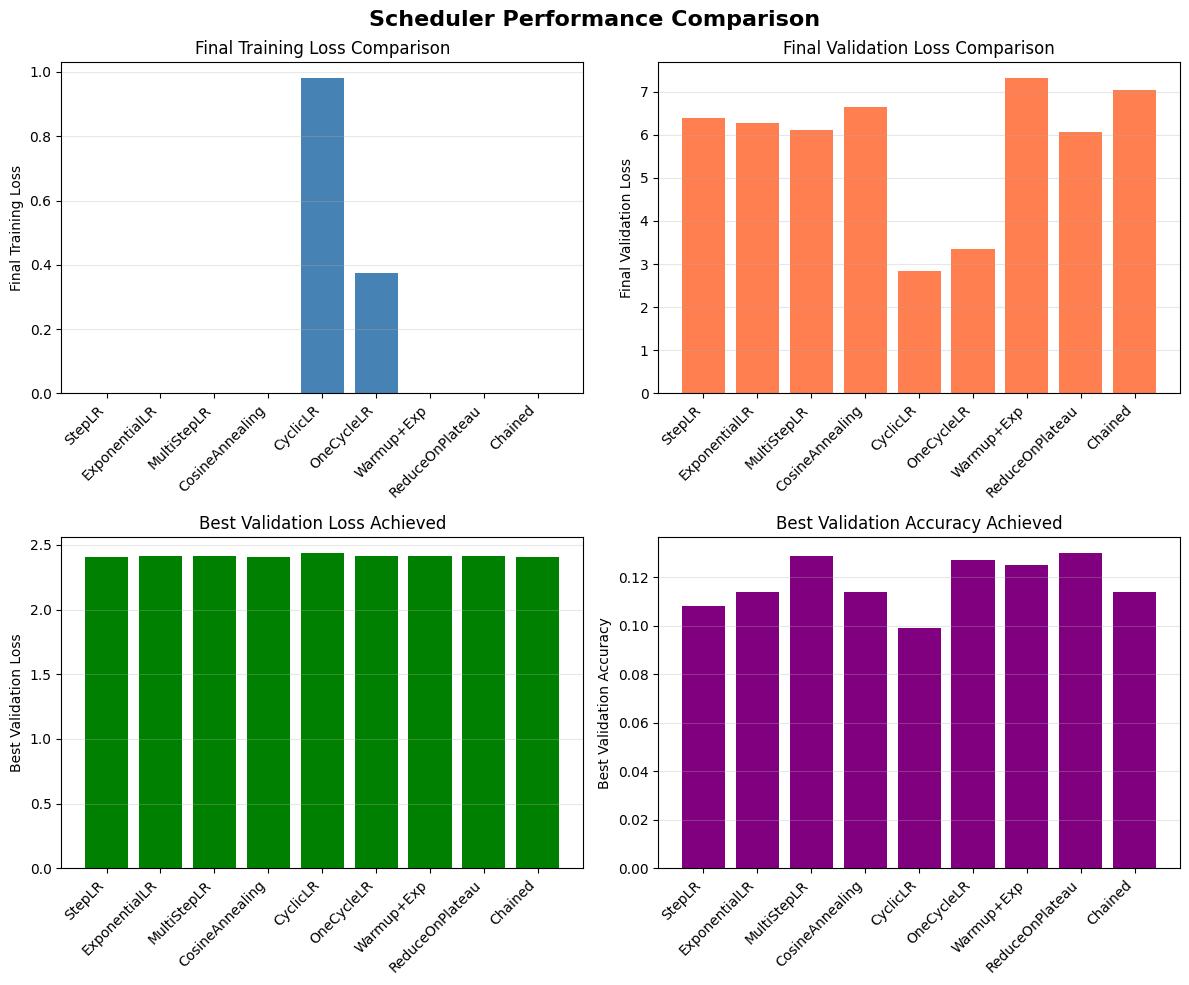


Scheduler            Final Train Loss   Best Val Loss      Best Val Acc   
StepLR               0.0008             2.4039             0.1080         
ExponentialLR        0.0009             2.4179             0.1140         
MultiStepLR          0.0013             2.4179             0.1290         
CosineAnnealing      0.0006             2.4058             0.1140         
CyclicLR             0.9810             2.4366             0.0990         
OneCycleLR           0.3730             2.4134             0.1270         
Warmup+Exp           0.0002             2.4117             0.1250         
ReduceOnPlateau      0.0015             2.4152             0.1300         
Chained              0.0003             2.4091             0.1140         


In [18]:
def compare_scheduler_performance():
    """Compare final metrics for all schedulers."""

    schedulers = [
        'StepLR', 'ExponentialLR', 'MultiStepLR',
        'CosineAnnealing', 'CyclicLR', 'OneCycleLR',
        'Warmup+Exp', 'ReduceOnPlateau', 'Chained'
    ]

    histories = [
        history_step, history_exp, history_multistep,
        history_cosine, history_cyclic, history_onecycle,
        history_warmup, history_plateau, history_chained
    ]

    # Collect metrics
    final_train_loss = [h['train_loss'][-1] for h in histories]
    final_val_loss = [h['val_loss'][-1] for h in histories]
    best_val_loss = [min(h['val_loss']) for h in histories]
    best_val_acc = [max(h.get('val_acc', [0])) for h in histories]

    # Create comparison plot
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # Final training loss
    ax = axes[0, 0]
    bars = ax.bar(range(len(schedulers)), final_train_loss, color='steelblue')
    ax.set_xticks(range(len(schedulers)))
    ax.set_xticklabels(schedulers, rotation=45, ha='right')
    ax.set_ylabel('Final Training Loss')
    ax.set_title('Final Training Loss Comparison')
    ax.grid(True, alpha=0.3, axis='y')

    # Final validation loss
    ax = axes[0, 1]
    bars = ax.bar(range(len(schedulers)), final_val_loss, color='coral')
    ax.set_xticks(range(len(schedulers)))
    ax.set_xticklabels(schedulers, rotation=45, ha='right')
    ax.set_ylabel('Final Validation Loss')
    ax.set_title('Final Validation Loss Comparison')
    ax.grid(True, alpha=0.3, axis='y')

    # Best validation loss
    ax = axes[1, 0]
    bars = ax.bar(range(len(schedulers)), best_val_loss, color='green')
    ax.set_xticks(range(len(schedulers)))
    ax.set_xticklabels(schedulers, rotation=45, ha='right')
    ax.set_ylabel('Best Validation Loss')
    ax.set_title('Best Validation Loss Achieved')
    ax.grid(True, alpha=0.3, axis='y')

    # Best validation accuracy
    ax = axes[1, 1]
    bars = ax.bar(range(len(schedulers)), best_val_acc, color='purple')
    ax.set_xticks(range(len(schedulers)))
    ax.set_xticklabels(schedulers, rotation=45, ha='right')
    ax.set_ylabel('Best Validation Accuracy')
    ax.set_title('Best Validation Accuracy Achieved')
    ax.grid(True, alpha=0.3, axis='y')

    plt.suptitle('Scheduler Performance Comparison', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Print summary table
    print("\n" + "=" * 80)
    print(f"{'Scheduler':<20} {'Final Train Loss':<18} {'Best Val Loss':<18} {'Best Val Acc':<15}")
    print("=" * 80)

    for name, ftl, bvl, bva in zip(schedulers, final_train_loss, best_val_loss, best_val_acc):
        print(f"{name:<20} {ftl:<18.4f} {bvl:<18.4f} {bva:<15.4f}")
    print("=" * 80)


compare_scheduler_performance()

## Summary and Best Practices

### Key Takeaways

1. **Basic Schedulers (StepLR, ExponentialLR, MultiStepLR)**
   - Simple and predictable
   - Good for well-understood problems
   - StepLR: Discrete drops at fixed intervals
   - ExponentialLR: Smooth exponential decay
   - MultiStepLR: Custom control over decay points

2. **Advanced Schedulers**
   - **CosineAnnealing**: Smooth periodic decay, good for avoiding local minima
   - **CyclicLR**: Oscillating learning rates can help escape saddle points
   - **OneCycleLR**: Super-convergence for faster training

3. **Adaptive Strategies**
   - **Warmup**: Essential for large models and batch sizes
   - **ReduceLROnPlateau**: Automatically adapts to training progress
   - **Chained Schedulers**: Combine multiple strategies for complex training regimes

### When to Use Each Scheduler

| Scheduler | Best For | Key Advantage |
|-----------|----------|---------------|
| StepLR | Known training duration | Simple and predictable |
| ExponentialLR | Smooth decay needed | Gradual reduction |
| MultiStepLR | Domain-specific knowledge | Precise control |
| CosineAnnealing | Avoiding local minima | Smooth annealing |
| CyclicLR | Escaping saddle points | Dynamic exploration |
| OneCycleLR | Fast convergence | Super-convergence |
| Warmup | Large models/batches | Stable initialization |
| ReduceLROnPlateau | Unknown optimal schedule | Automatic adaptation |
| Chained | Complex training | Maximum flexibility |


## Exercises

1. **Custom Scheduler**: Implement a polynomial decay scheduler where `lr = init_lr * (1 - epoch/max_epoch)^power`

2. **Warmup Variants**: Create a cosine warmup instead of linear warmup

3. **Adaptive Cyclic**: Combine CyclicLR with ReduceLROnPlateau for adaptive cycling

4. **Restart Strategies**: Implement SGDR (SGD with warm restarts) using cosine annealing

5. **Learning Rate Finder**: Implement the learning rate range test to find optimal learning rates

6. **Schedule Visualization**: Create an interactive tool to visualize and compare different schedules before training
